<a href="https://www.kaggle.com/code/sharanharsoor/spanish-to-english-translation?scriptVersionId=125503000" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Aim of the notebook.
attention-based sequence-to-sequence model that can effectively understand the context of Spanish sentences and translate them into clear and coherent English sentences.

In [1]:
import os,io
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import tensorflow as tf
import warnings
warnings.filterwarnings('ignore')

# Downloading the dataset

The dataset used is a paired corpus of **English-Spanish**, provided by [Anki](https://www.manythings.org/anki/).

The code starts by downloading a zip file containing the dataset for English to Spanish translation. The dataset is stored in the `spa-eng` folder and can be found in the file named `spa.txt`.

Let's take a look at how the data looks like

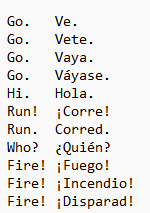

- Each line in the `spa.txt` file contains an English word/sentence and their corresponding Spanish translation.

- Some words might have multiple translation because of context. 

- Our first objective is to extract each line, and then separate the  English and Spanish words/sentences into two separate arrays. These will act as our input and target sentences for training the model

In [2]:
# Downloading the file 
zip_file = tf.keras.utils.get_file(
    'spa-eng.zip', origin='http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip',
    extract=True)

file_path = os.path.dirname(zip_file)+"/spa-eng/spa.txt" 

2638744/2638744 [==============================] - 0s 0us/step


In [3]:
! head -10 /root/.keras/datasets/spa-eng/spa.txt

Go.	Ve.
Go.	Vete.
Go.	Vaya.
Go.	Váyase.
Hi.	Hola.
Run!	¡Corre!
Run.	Corred.
Who?	¿Quién?
Fire!	¡Fuego!
Fire!	¡Incendio!


# Load the data

In [4]:
def load_data(path, size=None):
    text = io.open(file_path, encoding='UTF-8').read()
    lines = text.splitlines()
    pairs = [line.split('\t') for line in lines]

    # lines =  # split the text into lines separated by newline # Insert Code Here ----
    # pairs =  # split each line into source and target using tabs # Insert Code Here ----

    source = np.array([source for target, source in pairs])  # extract source text into a numpy array
    target = np.array([target for target, source in pairs])  # extract target text into a numpy array

    return source, target


In [5]:
src_sentences, tgt_sentences = load_data(file_path)
print("Original Sentence:",src_sentences[42])
print("Translated Sentence:",tgt_sentences[42])

Original Sentence: Yo lo sé.
Translated Sentence: I know.


# Visualize the data

In [6]:
#Create a dataframe 
df = pd.DataFrame(zip(src_sentences, tgt_sentences), columns=['source_sentence', 'target_sentence'])
df

,source_sentence,target_sentence
0,Ve.,Go.
1,Vete.,Go.
2,Vaya.,Go.
3,Váyase.,Go.
4,Hola.,Hi.
...,...,...
118959,Hay cuatro causas principales de muertes relac...,There are four main causes of alcohol-related ...
118960,Hay madres y padres que se quedan despiertos d...,There are mothers and fathers who will lie awa...
118961,Una huella de carbono es la cantidad de contam...,A carbon footprint is the amount of carbon dio...
118962,Como suele haber varias páginas web sobre cual...,Since there are usually multiple websites on a...


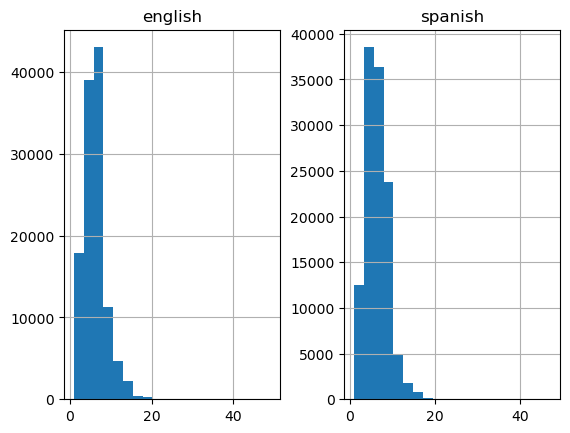

In [7]:
eng_len = []
span_len = []

# populate the lists with sentence lengths
for i in src_sentences:
      eng_len.append(len(i.split()))  

for i in tgt_sentences:
      span_len.append(len(i.split()))

length_df = pd.DataFrame({'english':eng_len, 'spanish':span_len})

length_df.hist(bins = 20)
plt.show()

# Process the data

In [8]:
import re, itertools
from collections import Counter
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

## Text Standardization

The model is dealing with multilingual text with a limited vocabulary. So it will be important to standardize the input text. The first step is Unicode normalization to split accented characters and replace compatibility characters with their ASCII equivalents.

For example 

- Input: Yo lo sé.
- Output: <*sos*> yo lo se . <*eos*>

In [9]:
import unicodedata

def unicode_to_ascii(s):
    normalized = unicodedata.normalize('NFD', s)
    return ''.join(c for c in normalized if unicodedata.category(c) != 'Mn')
     
def preprocess_text(text):
  text = unicode_to_ascii(text.lower().strip())
  text = re.sub(r"[^a-zA-Z?.!,¿]+", " ", text)
  text = re.sub(r"([?.!,¿])", r" \1 ", text)
  text = re.sub(r'[" "]+', " ", text)
  text = text.rstrip().strip()
  text = '<sos> ' + text + ' <eos>'

  return text


In [10]:
print('Original sentence:',src_sentences[42])
prc_src_sentences = [preprocess_text(w) for w in src_sentences]
prc_tgt_sentences = [preprocess_text(w) for w in tgt_sentences]
print('Preprocessed sentence:',prc_src_sentences[42])

Original sentence: Yo lo sé.
Preprocessed sentence: <sos> yo lo se . <eos>


# Tokenize the data
Once, the sentences are splitted and special tokens are added, the process of tokenization is carried out using the **Tokenizer** class from the **tensorflow.keras.preprocessing.text** module. 

Steps:

* The Tokenizer object is initialized and fit to the text data. 
* The texts are then tokenized, meaning that each word is assigned a unique number. 
* The resulting sequences are then padded and truncated to make all of them of equal length.

We'll create a function named `tokenize` to perform all the above steps together. Here's an example of how the function will transform an input sentence:

- Input: <*sos*> yo lo se . <*eos*>
- Output:  [ 1 26 18 17  3  2  0  0  0  0  0  0  0  0  0  0]

In [11]:
def tokenize(sentences): 
    lang_tokenizer = Tokenizer( filters='')
    lang_tokenizer.fit_on_texts(sentences)
    sequences = lang_tokenizer.texts_to_sequences(sentences)
    max_length = max(len(s) for s in sequences)
    sequences = pad_sequences(sequences, maxlen=max_length, padding='post', truncating='post')

    return sequences, lang_tokenizer, max_length


## Create source and target sequences using tokenize()

Before we apply the tokenize() function, we need to make an important consideration. We won't be able to apply the processing and tokenization function to the entire dataset as it will exhaust all the available RAM. Hence, it is recommended to limit the data. Training on the complete dataset of >100,000 sentences will take a long time.

To filter the data, process & tokenize them, we can build a function load_sequences that perform all the three tasks inside it. This function will return the source, target sequences, their maximum length & the tokenisers used for them.

In [12]:
def load_sequences(path, size=None):
    src_sentences, tgt_sentences = load_data(path)
    src_sentences = [preprocess_text(w) for w in src_sentences]
    tgt_sentences = [preprocess_text(w) for w in tgt_sentences]

    src_sequences,src_lang_tokenizer,max_length_src = tokenize(src_sentences)
    tgt_sequences,tgt_lang_tokenizer,max_length_trg = tokenize(tgt_sentences)

    return src_sequences, tgt_sequences, src_lang_tokenizer, tgt_lang_tokenizer, max_length_src, max_length_trg


In [13]:
src_sequences, tgt_sequences, src_lang_tokenizer, tgt_lang_tokenizer, max_length_src, max_length_trg = load_sequences(file_path)
print("src sequences:",src_sequences.shape)
print("tgt sequences:",tgt_sequences.shape)
print("source maxlen:",max_length_src)
print("target maxlen:",max_length_trg)

src sequences: (118964, 53)
tgt sequences: (118964, 51)
source maxlen: 53
target maxlen: 51


In [14]:
print("Original sentence:", src_sentences[42])
print("Text after preprocessing:", preprocess_text(src_sentences[42]))
print("Text after tokenization :", src_sequences[42])

Original sentence: Yo lo sé.
Text after preprocessing: <sos> yo lo se . <eos>
Text after tokenization : [ 1 38 21 16  3  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0]


In [15]:
print("Original sentence:", tgt_sentences[42])
print("Text after preprocessing:", preprocess_text(tgt_sentences[42]))
print("Text after tokenization :", tgt_sequences[42])

Original sentence: I know.
Text after preprocessing: <sos> i know . <eos>
Text after tokenization : [ 1  4 45  3  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0]


## Understanding what's happening inside
We're taking another detour here, to understand how the tokenisation layer converts a batch of strings into a batch of token IDs. 

Using the **.index_word()** method, we can convert the token IDs back to words for understanding the mapping and what's under the hood.


In [16]:
#Testing if the word to index / index to word mappings have been obtained correctly. 
def convert(lang, tensor):
  for t in tensor:
    if t!=0:
      print ("%d ----> %s" % (t, lang.index_word[t]))

print ("Input Language; index to word mapping")
convert(src_lang_tokenizer, src_sequences[42])
print ()
print ("Target Language; index to word mapping")
convert(tgt_lang_tokenizer, tgt_sequences[42])

Input Language; index to word mapping
1 ----> <sos>
38 ----> yo
21 ----> lo
16 ----> se
3 ----> .
2 ----> <eos>

Target Language; index to word mapping
1 ----> <sos>
4 ----> i
45 ----> know
3 ----> .
2 ----> <eos>


In [17]:
# getting the size of the input and output vocabularies.

src_vocab_size = len(src_lang_tokenizer.word_index)+1 
tgt_vocab_size = len(tgt_lang_tokenizer.word_index)+1 
print(src_vocab_size)
print(tgt_vocab_size)

24794
12934


 # Train-Test Split
 Now that we have processed the data, it's time to split it into train and test datasets. This way, we can use the train data to train our model and evaluate the model performance on the test data.

The train_test_split() function from the sklearn library is used to split the data. src_sequences and tgt_sequences are the input and target sequences respectively. The test_size parameter specifies the proportion of the data that should be used for testing, and random_state is used to set the random seed for reproducibility.

In [18]:
source_sequences_train,source_sequences_val,tgt_sequences_train,tgt_sequences_val = train_test_split(src_sequences, tgt_sequences, shuffle=False, test_size=0.2)
print(len(source_sequences_train),len(source_sequences_val),len(tgt_sequences_train),len(tgt_sequences_val))

95171 23793 95171 23793


In [19]:
print(source_sequences_train[1])
print(source_sequences_val[1])
print(tgt_sequences_train[1])
print(tgt_sequences_val[1])

[   1 1321    3    2    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0]
[  1  29  21 315  18  94   8 549 440   3   2   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
[ 1 49  3  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0]
[  1   4 125   7  20  96   7  65  12 311 763   3   2   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]


## Create a tf.dataset
The input pipeline starts from importing the data and creating a dataset from the data stored in the memory. For this, you can use `tf.data.Dataset.from_tensor_slices()`, which creates a **tf.data.Dataset** the object whose elements are slices of the passed tensors. Once you have created the object, you can transform it by applying different operations to the dataset object. (for example, Dataset.map() orDataset.batch()).

From the arrays of sequences created ater tokenisation, you can create a tf.data.Dataset of strings that shuffles and batches them efficiently

# Defining Hyperparameters
The following hyperparameters for the creating the **tf.dataset** (and later for model building purposes as well) are specified:
- `buffer_size`: This represents the buffer size for the training data. It is calculated by taking the length of the `source_sequences_train` array.
- `val_buffer_size`: This represents the buffer size for the validation data. It is calculated by taking the length of the `source_sequences_val` array.
- `BATCH_SIZE`: This represents the batch size for the training process. It is set to 64.
- `embedding_dim`: This represents the embedding dimension for the input data. It is set to 128.
- `units`: This represents the number of units in the recurrent neural network (RNN) used for the model. It is set to 1024.
- `steps_per_epoch`: This represents the number of steps to take during each epoch of training. It is calculated as the `buffer_size` divided by the `BATCH_SIZE`.
- `val_steps_per_epoch`: This represents the number of validation steps to take during each epoch of training. It is calculated as the `val_buffer_size` divided by the `BATCH_SIZE`.
It is important to note that these hyperparameters have been selected based on heuristics and may need to be fine-tuned for different problems or data sets.

In [20]:
#Defining hyperparameters
buffer_size=len(source_sequences_train)
val_buffer_size = len(source_sequences_val)
BATCH_SIZE = 64
embedding_dim = 128
units = 1024 
steps_per_epoch = buffer_size//BATCH_SIZE
val_steps_per_epoch = val_buffer_size//BATCH_SIZE

In [21]:
train_dataset = tf.data.Dataset.from_tensor_slices((source_sequences_train, tgt_sequences_train))

train_dataset = train_dataset.shuffle(buffer_size=buffer_size).batch(BATCH_SIZE)

val_dataset = tf.data.Dataset.from_tensor_slices((source_sequences_val, tgt_sequences_val))

val_dataset = val_dataset.batch(BATCH_SIZE)

In [22]:
example_input_batch, example_target_batch = next(iter(train_dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([64, 53]), TensorShape([64, 51]))

# Build the NMT model
## Encoder-Decoder model with attention
The encoder model consists of an embedding layer, a GRU layer with 1024 units.

The decoder model consists of an attention layer, a embedding layer, a GRU layer and a dense layer.

The attention model consists of three dense layers (BahdanauAttention Model) .

## Build the Encoder
The goal of the encoder is to process the context sequence into a sequence of vectors that are useful for the decoder as it attempts to predict the next output for each timestep.

---


The **Encoder** class is defined as a subclass of tf.keras.Model. It takes the following parameters as inputs:

> **Class constructor:**

* **vocab_size:** Integer representing the size of the vocabulary in the input language.
* **emb_dim:** Integer representing the dimension of the embedding space.
* **enc_units:** Integer representing the number of encoding GRU units.
* **batch_sz:** Integer representing the batch size used during training.


> It also initializes the following layers:

* An **Embedding layer**, which maps the input language word indices to dense vectors in the embedding space. mask_zero argument is set to True to mask the padding in the input sequence.
* A **GRU layer**, which performs the encoding of the input sequences.

> The **call** method is defined to perform the forward pass of the Encoder. It takes two inputs:

* x: Input sequences of shape (batch_size, sequence_length).
* hidden: The initial hidden state, with shape **(batch_size, enc_units)**.

> It does the following operations:
1. The method first maps the input sequences to the embedding space using the Embedding layer. The resulting output has shape (batch_size, sequence_length, emb_dim).
2. Then, the encoded sequence and the final hidden state are obtained by passing the embedded input through the GRU layer. The shape of the encoded sequence is **(batch_size, sequence_length, enc_units)** and the shape of the final hidden state is **(batch_size, enc_units).**
3. The initialize_hidden_state method is used to initialize the hidden state of the GRU layer to all zeros, with shape **(batch_size, enc_units).**


In [23]:
class Encoder(tf.keras.Model):

    def __init__(self, vocab_size, emb_dim, enc_units, batch_sz):
        super(Encoder, self).__init__()
        self.enc_units = enc_units 
        self.batch_sz = batch_sz 
        self.embedding = tf.keras.layers.Embedding(vocab_size, emb_dim,mask_zero=True)
        self.gru = tf.keras.layers.GRU(self.enc_units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform') 

    def call(self, x, hidden):
        x = self.embedding(x)
        output, state = self.gru(x, initial_state = hidden)
        return output, state 

    def initialize_hidden_state(self):
        return tf.zeros((self.batch_sz, self.enc_units))


In [24]:
encoder = Encoder(src_vocab_size, embedding_dim, units, BATCH_SIZE) 

sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)
print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))

Encoder output shape: (batch size, sequence length, units) (64, 53, 1024)
Encoder Hidden state shape: (batch size, units) (64, 1024)


## Bahdanau Attention Layer
This class implements the Bahdanau Attention mechanism in TensorFlow as a custom layer. The class extends the **tf.keras.layers.Layer** class and overrides the call method to implement the Bahdanau attention mechanism.

We will use the subclassing approach again for building the Attention layer as we have done for the Encoder. This will help us in training all of the sub-layers inside it together during the end-to-end training process of the NMT model.

>**Architecture**
The Bahdanau Attention layer consists of three fully-connected dense layers:
1. **W1**: the first dense layer with units number of units.
2. **W2**: the second dense layer with units number of units.
3. **V**: the third dense layer with 1 unit.

> **Inputs:**
The input to the call method are two tensors:
1. **Query**: a tensor with shape (batch_size, hidden size) representing the hidden state.
2. **Values**: a tensor with shape (batch_size, max_len, hidden size) representing the values to attend over.

> **Outputs:**
The outputs of the call method are:
1. **Context_vector**: a tensor with shape (batch_size, hidden_size) representing the context vector.
2. **Attention_weights**: a tensor with shape (batch_size, max_length, 1) representing the attention weights.

>**Algorithm**
* The query tensor is expanded along the time axis to broadcast addition with the values tensor.
* The score is calculated by applying the tanh activation on the result of the addition of W1(query_with_time_axis) and W2(values).
* The attention weights are obtained by applying the softmax activation on the score.
* The context vector is obtained by multiplying the attention weights with the values tensor and summing over the max length axis.
* Finally, both the context vector and the attention weights are returned.

In [25]:
class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units) # fully-connected dense layer-1
    self.W2 = tf.keras.layers.Dense(units) # fully-connected dense layer-2
    self.V = tf.keras.layers.Dense(1) # fully-connected dense layer-3

  def call(self, query, values):
   
    query_with_time_axis = tf.expand_dims(query, 1)
    score = self.V(tf.nn.tanh(self.W1(query_with_time_axis) + self.W2(values)))   
    attention_weights = tf.nn.softmax(score, axis=1)
    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [26]:
attention_layer = BahdanauAttention(20) 
attention_result, attention_weights = attention_layer(sample_hidden, sample_output) 

print("Attention result shape (context vector): (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

Attention result shape (context vector): (batch size, units) (64, 1024)
Attention weights shape: (batch_size, sequence_length, 1) (64, 53, 1)


## Build the decoder
The decoder's job is to generate predictions for the next token at each location in the target sequence.

---


This code defines a Decoder class that implements a decoder model for a sequence-to-sequence architecture. The decoder model will take in an input sequence and the hidden state from the encoder and generate the target sequence.

> **Class constructor**:The __init__ method initializes the class variables:

* **vocab_size**: The size of the target vocabulary.
*embedding_dim: The size of the embedding layer that converts the target sequence into dense vectors.
* **dec_units:** The number of GRU units in the decoder.
* **batch_sz:** The batch size of the input data.

> It also initializes the following layers:
* **attention**: An instance of the BahdanauAttention class.
* **Embedding**: An embedding layer to convert the target sequences into dense vectors.
* **GRU**: A GRU layer to perform the decoding.
* **FC**: A dense layer to generate the final target sequence.

>**call** method: The call method implements the forward pass of the decoder. It  takes in 3 inputs: x, hidden, and enc_output.

* x: Input sequences of shape (batch_size, sequence_length).
* hidden:  hidden state from the encoder hidden.  **(batch_size, dec_units)
* enc_output: The output of the encoder (shape: (batch_size, max_length, hidden_size)).

>It does the following operations:
1. Computes the context vector and the attention weights from the attention layer,
2. Embeds the input x using the embedding layer.
3. Concatenates the context vector with the embedded target sequence
4. Passes the concatenated sequence and the hidden state from the encoder to the GRU layer. This generates the output and the new hidden state.
3. Reshapes the output to a 2D tensor.
4. Passes the reshaped output through the dense layer to generate the final target sequence.
5. It returns the final target sequence and the new hidden state.

In [27]:
class Decoder(tf.keras.Model):
  def __init__(self, vocab_size, emb_dim, dec_units, batch_sz):
    super(Decoder, self).__init__()
    self.batch_sz = batch_sz 
    self.dec_units = dec_units 
    self.attention = BahdanauAttention(self.dec_units)
    
    self.embedding = tf.keras.layers.Embedding(vocab_size, emb_dim) 
    
    self.gru = tf.keras.layers.GRU(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform') 
    self.fc = tf.keras.layers.Dense(vocab_size)

  def call(self, x, hidden, enc_output):
    context_vector, attention_weights = self.attention(hidden, enc_output)
    x = self.embedding(x)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
    output, state = self.gru(x)
    output = tf.reshape(output, (-1, output.shape[2]))
    x = self.fc(output)
    return x, state , attention_weights


In [28]:
decoder = Decoder(tgt_vocab_size, embedding_dim, units, BATCH_SIZE)
sample_decoder_output, _, _ = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                      sample_hidden, sample_output)

print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

Decoder output shape: (batch_size, vocab size) (64, 12934)


# Train the NMT model
## Configure the model.
To train the model you'll need several additional components:

* **The Loss function**: The loss_function method calculates the loss between the target data and the model's prediction. The real argument is the target data, and the pred argument is the model's prediction.

> The method first creates a binary mask to indicate which target data points are not padding (not equal to 0). The loss is calculated using the loss_object and the masked loss is returned by taking the mean of the masked loss values.

* **The Optimizer** : Defines the optimizer and the loss function used to train the model. The optimizer used is Adam and the loss function used is SparseCategoricalCrossentropy.

> SparseCategoricalCrossentropy is used because the target data is a categorical variable, but not one-hot encoded, so we use this form of categorical crossentropy loss. The from_logits argument is set to True because the model produces logits rather than probabilistic outputs, and the reduction argument is set to none because the loss values need to be calculated for each time step and then masked.

* **Checkpoints**: The code defines the checkpoint and its directory. The checkpoint is a mechanism to save the model's state after each training epoch, so that we can resume training from the saved state if needed. 

>The checkpoint_dir is set to ./training_checkpoints and the checkpoint_prefix is set to ckpt inside the checkpoint_dir. The checkpoint is then defined using the tf.train.Checkpoint method, and includes the optimizer, the encoder and the decoder as its attributes.

Here's an implementation of a masked loss and accuracy:

In [29]:
optimizer = tf.keras.optimizers.Adam() 

loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')  



def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))  
  loss_ = loss_object(real, pred)  

  mask = tf.cast(mask, dtype=loss_.dtype) 
  loss_ *= mask

  return tf.reduce_mean(loss_)


checkpoint_dir = './training_checkpoints'  
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")  
checkpoint = tf.train.Checkpoint(optimizer=optimizer,  
                                 encoder=encoder,
                                 decoder=decoder)


## Configure the training step:
A custom training loop (instead of Model.Fit etc.) is used for which further reference is available from Tensorflow [here](https://www.tensorflow.org/guide/keras/writing_a_training_loop_from_scratch)

NOTE: While training the model, make sure your instance is GPU based.

---



The code is annotated with "@tf.function", which tells TensorFlow to compile this function for performance optimization. 
This is a TensorFlow function for a single training step of a sequence-to-sequence model. The input to the function includes:
- `inp`: The input sequence to be encoded
- `targ`: The target sequence to be decoded
- `enc_hidden`: The initial hidden state of the encoder

> The function performs the following operations:
1. Encode the input sequence to get the encoded output and the final hidden state of the encoder.
2. Set the initial hidden state of the decoder to the final hidden state of the encoder.
3. Loop over the time steps of the target sequence to be passed as current input along with the hidden state and encoder output to get the predicted output and the next hidden state.
4. Computing the loss between the target and the predicted output for each time step.
5. Comparing the gradients of the loss with respect to the trainable variables of the encoder and decoder.
6. Update the variables based on the computed gradients using an optimiser.


In [30]:
@tf.function
def train_step(inp, targ, enc_hidden):
  loss = 0

  with tf.GradientTape() as tape:
    enc_output, enc_hidden = encoder(inp, enc_hidden) 

    dec_hidden = enc_hidden 

    dec_input = tf.expand_dims([tgt_lang_tokenizer.word_index['<sos>']] * BATCH_SIZE, 1) 

    for t in range(1, targ.shape[1]):
      predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output) 

      loss += loss_function(targ[:, t], predictions) 

      dec_input = tf.expand_dims(targ[:, t], 1) 

  batch_loss = (loss / int(targ.shape[1])) 

  variables = encoder.trainable_variables + decoder.trainable_variables 

  gradients = tape.gradient(loss, variables) 
  optimizer.apply_gradients(zip(gradients, variables))

  return batch_loss


## Configure the validation step:
The purpose of the validation step is to evaluate the model's performance on a validation dataset and to monitor the training process.

---
This is a TensorFlow function for a single validation step of a sequence-to-sequence model. The input to the function includes:
- `inp`: The input sequence to be encoded
- `targ`: The target sequence to be decoded
- `enc_hidden`: The initial hidden state of the encoder

>The function performs the following operations:
1. Encoding the input sequence to get the encoded output and the final hidden state of the encoder
2. Setting the initial hidden state of the decoder to be the final hidden state of the encoder
3. Looping over the time steps of the target sequence, passing the current input and hidden state to the decoder, along with the encoder output, to get the predicted output
4. Computing the loss between the target and the predicted output for each time step
5. Computing the average loss over all time steps
6. Returning the average loss for this batch

In [31]:
@tf.function
def val_step(inp, targ, enc_hidden):
    loss = 0 
    enc_output, enc_hidden = encoder(inp, enc_hidden) 
    dec_hidden = enc_hidden
    dec_input =  tf.expand_dims([tgt_lang_tokenizer.word_index['<sos>']] * BATCH_SIZE, 1)

    for t in range(1, targ.shape[1]): 
        predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output) 
        loss += loss_function(targ[:, t], predictions) 
        dec_input = tf.expand_dims(targ[:, t], 1) 

    batch_loss = (loss / int(targ.shape[1])) 

    return batch_loss 

#  Initiate the model training:

The following code trains a sequence to sequence model using the training and validation datasets. The model will be trained for 10 epochs.

> At each epoch:
* Step 1: Initialise Encoder’s hidden state
* Step 2: Invoke train_step function
* Step 3: Generate loss for each batch of the training dataset 
* Step 4: Accumulate loss to calculate the total training loss.
* Step 5: Invoke train_step function
* Step 6: Generate loss for each batch of the validation dataset 
* Step 7: Accumulate loss to calculate the total validation loss
* Step 8: Store model after every 2 epochs
* Step 9: Print metrics score

---

In [32]:
import time

def train_and_validate(train_dataset, val_dataset, EPOCHS=10):
    for epoch in range(EPOCHS):
        start = time.time()

        #Step1: 
        enc_hidden = encoder.initialize_hidden_state()
        total_train_loss = 0
        total_val_loss = 0
        for (batch, (inp, targ)) in enumerate(train_dataset.take(steps_per_epoch)):
            batch_loss = train_step(inp, targ, enc_hidden)
            total_train_loss += batch_loss 

            if batch % 100 == 0:
                print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                            batch,
                                                            batch_loss.numpy()))
       
        for (batch, (inp, targ)) in enumerate(val_dataset.take(val_steps_per_epoch)):    
            val_batch_loss = val_step(inp, targ, enc_hidden) 
            total_val_loss += val_batch_loss 

        if (epoch + 1) % 2 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)
        
        print('Total training loss is {:.4f}'.format(total_train_loss / steps_per_epoch))
        print('Total validation loss is {:.4f}'.format( total_val_loss / val_steps_per_epoch))
        print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))


In [33]:
train_and_validate(train_dataset, val_dataset)

Epoch 1 Batch 0 Loss 1.4590
Epoch 1 Batch 100 Loss 0.7274
Epoch 1 Batch 200 Loss 0.6359
Epoch 1 Batch 300 Loss 0.5868
Epoch 1 Batch 400 Loss 0.6192
Epoch 1 Batch 500 Loss 0.5914
Epoch 1 Batch 600 Loss 0.5632
Epoch 1 Batch 700 Loss 0.5178
Epoch 1 Batch 800 Loss 0.5278
Epoch 1 Batch 900 Loss 0.5410
Epoch 1 Batch 1000 Loss 0.5190
Epoch 1 Batch 1100 Loss 0.5044
Epoch 1 Batch 1200 Loss 0.5095
Epoch 1 Batch 1300 Loss 0.4727
Epoch 1 Batch 1400 Loss 0.5227
Total training loss is 0.5681
Total validation loss is 1.0691
Time taken for 1 epoch 716.4823491573334 sec

Epoch 2 Batch 0 Loss 0.4726
Epoch 2 Batch 100 Loss 0.4327
Epoch 2 Batch 200 Loss 0.4629
Epoch 2 Batch 300 Loss 0.4499
Epoch 2 Batch 400 Loss 0.4538
Epoch 2 Batch 500 Loss 0.4566
Epoch 2 Batch 600 Loss 0.4339
Epoch 2 Batch 700 Loss 0.3841
Epoch 2 Batch 800 Loss 0.4102
Epoch 2 Batch 900 Loss 0.3842
Epoch 2 Batch 1000 Loss 0.3620
Epoch 2 Batch 1100 Loss 0.3191
Epoch 2 Batch 1200 Loss 0.3743
Epoch 2 Batch 1300 Loss 0.3145
Epoch 2 Batch 140

# **Prediction using Greedy Search**

During inference i.e during testing, we change the prediction process slightly.
The code evaluate(sentence) defines a function that takes a sentence as input and returns the translated result along with the original sentence and an attention plot. Here's how the code performs these steps:

1. Initialize the attention plot with zeros, with shape (max_length_tgt, max_length_src).
2. Preprocess the input sentence by splitting it into words and converting each word into its corresponding index in the source tokenizer vocabulary.
3. Pad the input sequence with zeros to a fixed length max_length_src.
4. Convert the input sequence into a tensor.
5. Initialize the hidden state of the encoder with zeros.
6. Pass the input sequence through the encoder and get the output and the final hidden state.
7. Initialize the hidden state of the decoder with the final hidden state of the encoder.
8. Initialize the decoder input with the index of the special symbol <sos>.
9. For t in range(max_length_tgt):
>* Pass the decoder input, hidden state and the encoder output through the decoder and get the predictions and attention weights.
>* Add the attention weights to the attention plot.
>* Get the index of the word with the highest predicted probability and add it to the result string.
>* If the word is the special symbol <eos>, return the result, the original sentence, and the attention plot.
>* Set the decoder input to be the index of the word with the highest predicted probability.
10. Return the result, the original sentence, and the attention plot.

## Attention plot

The function for plotting the attention weights that takes three arguments: **attention, sentence, and predicted_sentence.**
* Create a figure and set its size to 10 x 10 using plt.figure(figsize=(10, 10)).
* Add a subplot of 1 x 1 grid and select the first subplot using fig.add_subplot(1, 1, 1).
* Display the attention weights with a heatmap using ax.matshow(attention, cmap='viridis').
* Create a font dictionary to set the font size of the tick labels to 14.
* Set the x-axis tick labels to sentence and the y-axis tick labels to predicted_sentence with a font size of 14.
* Set the x-axis major locator to tick every 1 and the y-axis major locator to tick every 1 using ax.xaxis.set_major_locator(ticker.MultipleLocator(1)) and ax.yaxis.set_major_locator(ticker.MultipleLocator(1)).
* Display the plot using plt.show().

In [34]:
def plot_attention(attention, sentence, predicted_sentence):
  fig = plt.figure(figsize=(10, 10))
  ax = fig.add_subplot(1, 1, 1)
  ax.matshow(attention, cmap='viridis')
  fontdict = {'fontsize': 14}
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)
  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
  plt.show()


In [35]:
def evaluate(sentence):
    attention_plot = np.zeros((max_length_trg, max_length_src))
    sentence = preprocess_text(sentence)
    inputs = [src_lang_tokenizer.word_index[i] for i in sentence.split(' ')]
    inputs = pad_sequences([inputs],
                          maxlen=max_length_src,
                          padding='post')
    inputs = tf.convert_to_tensor(inputs)

    result = ''
    hidden = [tf.zeros((1, units))]
    enc_out, enc_hidden = encoder(inputs, hidden)
    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([tgt_lang_tokenizer.word_index['<sos>']], 0)

    for t in range(max_length_trg):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                         dec_hidden,
                                                         enc_out)
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t] = attention_weights.numpy()
        predicted_id = tf.argmax(predictions[0]).numpy()
        result += tgt_lang_tokenizer.index_word[predicted_id] + ' '

        if tgt_lang_tokenizer.index_word[predicted_id] == '<eos>':
            return result, sentence, attention_plot
        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention_plot


In [36]:
def translate(sentence):
  result, sentence, attention_plot = evaluate(sentence)

  print('Input:', sentence)
  print('Predicted Translation:', result)

  attention_plot = attention_plot[:len(result.split(' ')),
                                  :len(sentence.split(' '))]
  plot_attention(attention_plot, sentence.split(' '), result.split(' '))

In [37]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

Input: <sos> hace mucho frio aqui . <eos>
Predicted Translation: it s very cold here . <eos> 


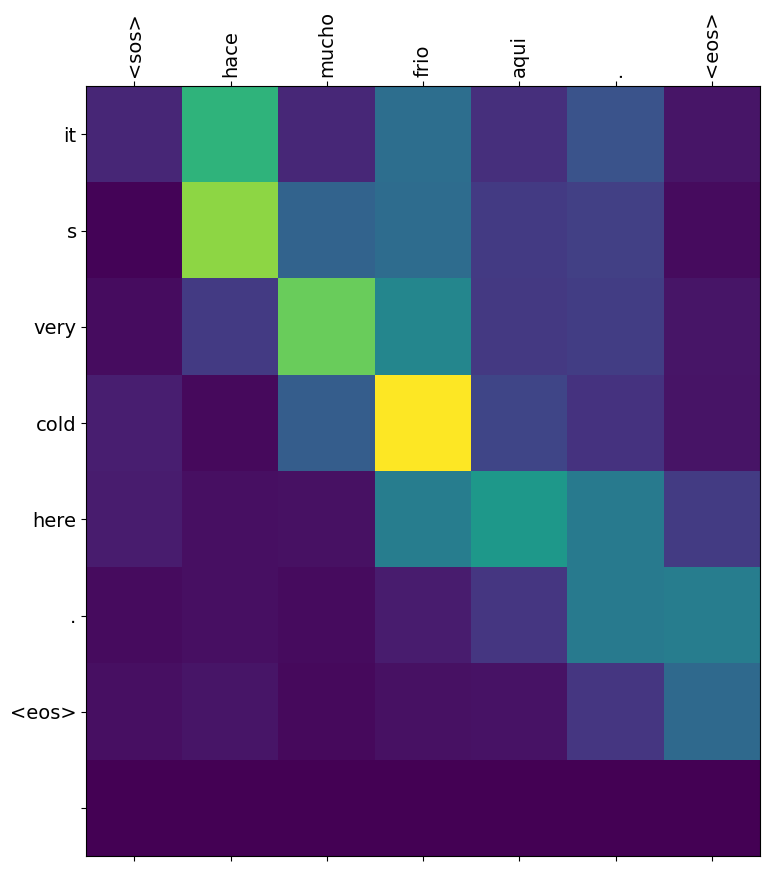

In [38]:
translate(u'hace mucho frío aquí.')

Input: <sos> trata de averiguarlo . <eos>
Predicted Translation: try to figure it out . <eos> 


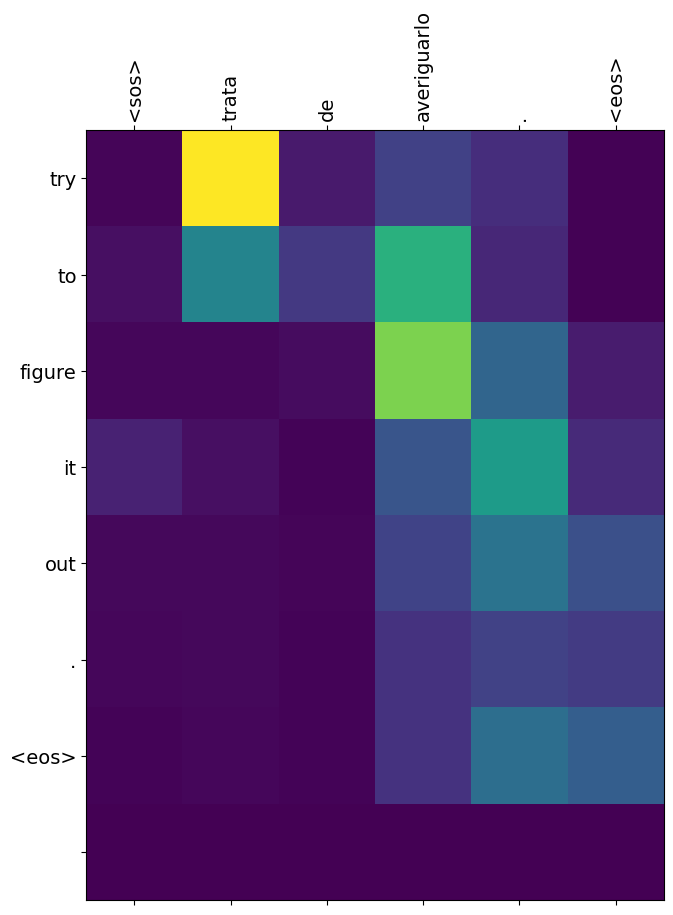

In [39]:
translate(u'trata de averiguarlo.')

Input: <sos> ¿ todavia estan en casa ? <eos>
Predicted Translation: are you still at home ? <eos> 


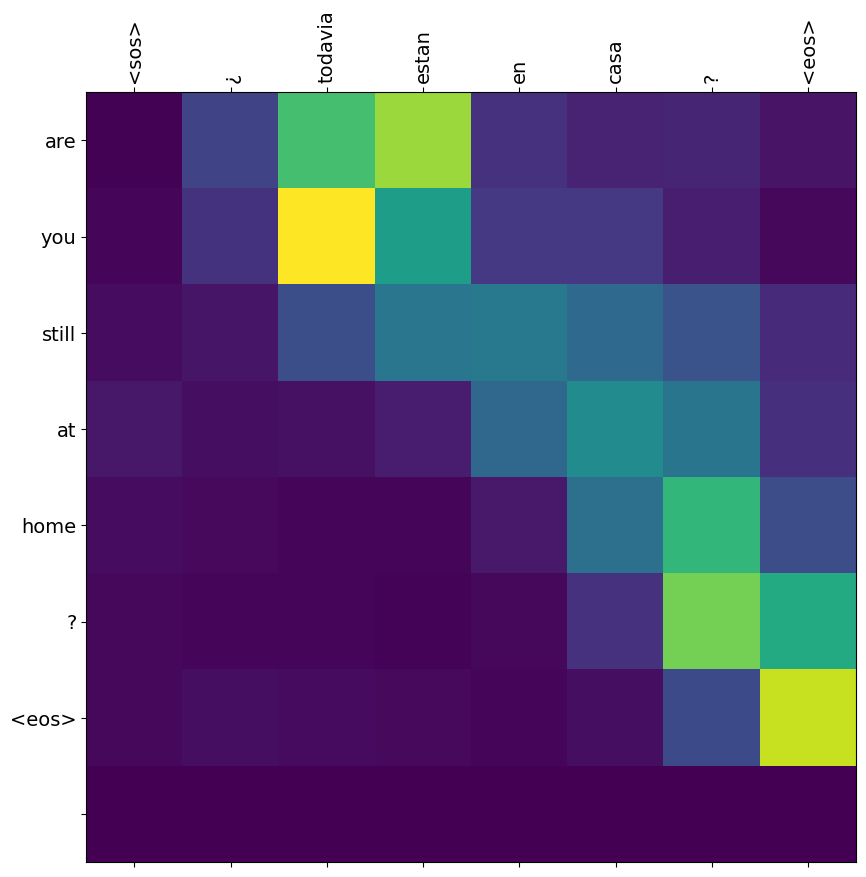

In [40]:
translate(u'¿todavía están en casa?')

## **Happy Learning** ##